### Analyzing sensitivity of functions $f_N^*$ versus $f$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from itertools import product
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from mindreadingautobots.entropy_and_bayesian import boolean
import time
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [3]:
data_path_v3  = "./sample_f/SAN_sample_f_results_v3.csv"
df_v3 = pd.read_csv(data_path_v3)
data_path_v4 = "./sample_f/SAN_sample_f_results_v4.csv"
df_v4 = pd.read_csv(data_path_v4)
df = pd.concat([df_v3, df_v4])

In [4]:
df['avg_sens_diff'] = (df['sens_f'] - df['sens_g']) / df['n_bool']
df['err_diff'] = df['err_f'] - df['err_g']
df['val_err_vs_err_g'] = (1 - df['val_acc']) - df['err_g']

In [7]:
df.columns

Index(['epoch', 'train_loss', 'train_acc', 'val_acc', 'noiseless_val_acc',
       'final_train_acc', 'final_val_acc', 'final_noiseless_val_acc',
       'sensitivity', 'sens_f', 'sens_g', 'err_f', 'err_g', 'entropy', 'lr',
       'depth', 'd_model', 'dropout', 'heads', 'd_ffn', 'n_bool', 'n_bits',
       'bf_bool', 'avg_sens_diff', 'err_diff', 'val_err_vs_err_g'],
      dtype='object')

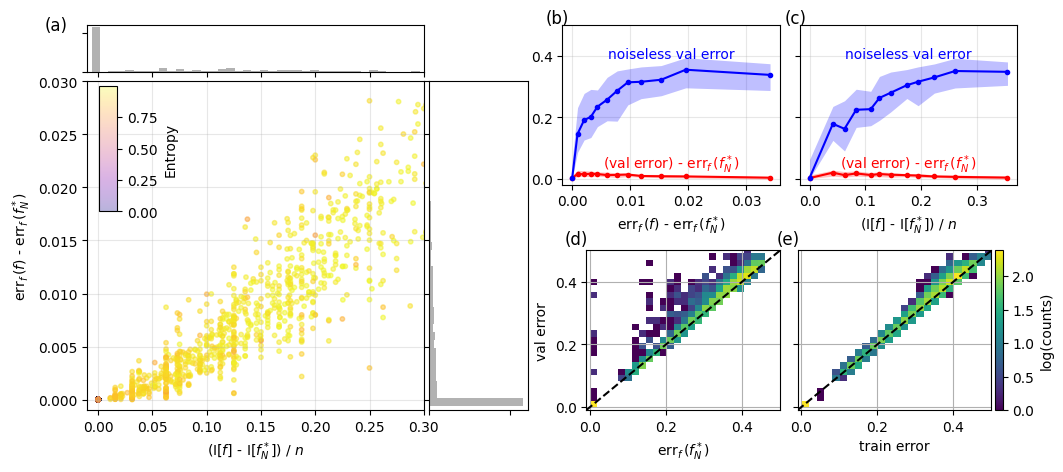

In [ ]:
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(7, 8)

sens_diff = df['avg_sens_diff'] # (I[f] - I[g]) / n
err_diff = df['err_diff'] # err(f) - err(g)

sens_diff_ub = 0.3
err_diff_ub = 0.03

ax_main = fig.add_subplot(gs[1:, :3])
ax_hist_x = fig.add_subplot(gs[0, :3])
ax_hist_y = fig.add_subplot(gs[1:, 3])

ax1 = fig.add_subplot(gs[0:3, 4:6])
ax2 = fig.add_subplot(gs[0:3, 6:8])
axes12 = [ax1, ax2]

ax3 = fig.add_subplot(gs[4:, 4:6])
ax4 = fig.add_subplot(gs[4:, 6:8])

# First plot: scatter plot of sensitivity difference 
cmap = 'plasma'
xmin = -0.01
ymin = -0.001
nbins = 40
sc = ax_main.scatter(
    sens_diff, 
    err_diff, 
    c=df['entropy'], 
    cmap=cmap, 
    alpha=0.3, 
    edgecolor=None, 
    s=10
)
ax_main.set_xlabel(r"(I[$f$] - I[$f_N^*$]) / $n$")
ax_main.set_ylabel(r"err$_f\,(f)$ - err$_f\,(f_N^*)$")

ax_main.grid(True, alpha=0.3)

# Shrink and move the colorbar inside ax_main (upper left corner)
pos = ax_main.get_position()
cbar_width = 0.015
cbar_height = 0.25
cbar_x = pos.x0 + 0.01
cbar_y = pos.y1 - cbar_height - 0.01
cax = fig.add_axes([cbar_x, cbar_y, cbar_width, cbar_height])
cbar = fig.colorbar(sc, cax=cax)
cbar.set_label('Entropy')
ax_main.grid(True)


# Top histogram (xvals distribution)
xbins = np.linspace(xmin, sens_diff_ub, nbins + 1)
dx = xbins[1] - xbins[0]
xbins = xbins - dx / 2
ax_hist_x.hist(sens_diff, alpha=0.3, bins=xbins, density=True, color='k')

# Right histogram (yvals distribution)
ybins = np.linspace(ymin, err_diff_ub, nbins + 1) 
dy = ybins[1] - ybins[0]
ybins = ybins - dy / 2
ax_hist_y.hist(err_diff, alpha=0.3, bins=ybins, density=True, orientation='horizontal', color='k')

for ax in [ax_hist_y, ax_hist_x]:
    # ax.set_xlabel('Density')
    ax.set_yticklabels([])
    # ax.set_ylabel('Density')
    ax.set_xticklabels([])
ax_main.set_xlim(xmin, sens_diff_ub)
ax_hist_x.set_xlim(xmin, sens_diff_ub)
ax_main.set_ylim(ymin, err_diff_ub)
ax_hist_y.set_ylim(ymin, err_diff_ub)

# Move ax_hist_y (the right histogram) to the left slightly by adjusting its position
pos = ax_hist_y.get_position()
# Decrease the x0 (left) and x1 (right) by a small amount, e.g., 0.02
shift = 0.012
ax_hist_y.set_position([pos.x0 - shift, pos.y0, pos.width, pos.height])


# first plot: err(f) - err(g), and vertical is err diff and noiseless val acc
ya = df['val_err_vs_err_g']
yb = 1 - df['noiseless_val_acc']

for i, (xvals, yvals1, yvals2) in enumerate([(err_diff, ya, yb), (sens_diff, ya, yb)]):
    dff = pd.DataFrame({'x': xvals, 'y1': yvals1, 'y2': yvals2}).sort_values('x')
    dff['bin'] = pd.qcut(dff['x'], q=20, duplicates='drop')
    g = dff.groupby('bin', observed=True)

    x_mid = g['x'].median().to_numpy()
    y1_med = g['y1'].median().to_numpy()
    y1_lo  = g['y1'].quantile(0.25).to_numpy()
    y1_hi  = g['y1'].quantile(0.75).to_numpy()

    y2_med = g['y2'].median().to_numpy()
    y2_lo  = g['y2'].quantile(0.25).to_numpy()
    y2_hi  = g['y2'].quantile(0.75).to_numpy()
    n_bin = g.size().to_numpy()
    ax = axes12[i]
    ax.plot(x_mid, y1_med, '-o', ms=3, zorder=3, color='r', label=r'$\hat{err}_f(\hat{f}) - err_f(f_N^*)$')
    ax.fill_between(x_mid, y1_lo, y1_hi, alpha=0.25, linewidth=0, zorder=2, color='r')
    ax.plot(x_mid, y2_med, '-o', ms=3, zorder=3, color='b')
    ax.fill_between(x_mid, y2_lo, y2_hi, alpha=0.25, linewidth=0, zorder=2, color='b')
    ax.text(0.5, 0.82, "noiseless val error", ha='center', va='center', transform=ax.transAxes, color='blue')
    ax.text(0.5, 0.13, r"(val error) - err$_f\,(f_N^*)$", ha='center', va='center', transform=ax.transAxes, color='red')

for ax in axes12:
    # ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.02, .5)
ax1.set_xlabel(r"err$_f\,(f)$ - err$_f\,(f_N^*)$")
ax2.set_xlabel(r"(I[$f$] - I[$f_N^*$]) / $n$")
ax2.set_yticklabels([])
print()


#############################################################################################

axes34 = [ax3, ax4]
# Compute 2D histogram and share a colorbar
pcms = []
for i, xvals in enumerate([df['err_g'], 1 - df['train_acc']]):
    ax = axes34[i]
    h, xedges, yedges = np.histogram2d(xvals, 1 - df['val_acc'], bins=25)
    h_masked = np.ma.masked_where(h == 0, h)
    log_h = np.ma.log10(h_masked)
    pcm = ax.pcolormesh(xedges, yedges, log_h.T, cmap='viridis')
    pcms.append(pcm)
# Add a single shared colorbar for both plots, scaling both histograms to the same colorbar
# Find the global min/max for the colorbar across both histograms
vmin = min(np.nanmin(np.ma.log10(np.ma.masked_where(np.histogram2d(xvals, 1 - df['val_acc'], bins=25)[0] == 0, 
                                                    np.histogram2d(xvals, 1 - df['val_acc'], bins=25)[0]))) for xvals in [df['err_g'], 1 - df['train_acc']])
vmax = max(np.nanmax(np.ma.log10(np.ma.masked_where(np.histogram2d(xvals, 1 - df['val_acc'], bins=25)[0] == 0, 
                                                    np.histogram2d(xvals, 1 - df['val_acc'], bins=25)[0]))) for xvals in [df['err_g'], 1 - df['train_acc']])
for pcm in pcms:
    pcm.set_clim(vmin, vmax)
fig.colorbar(pcms[0], ax=axes34, label='log(counts)', orientation='vertical', fraction=0.05, pad=0.06)

axes34[0].set_xlabel(r'err$_f\,(f_N^*)$')
axes34[1].set_xlabel('train error')
axes34[1].set_yticklabels([])
axes34[0].set_ylabel("val error")

for ax in axes34:
    ax.set_xlim([-0.01, 0.5])
    ax.set_ylim([-0.01, 0.5])
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    low = max(xmin, ymin)
    high = min(xmax, ymax)
    ax.grid(True)
    ax.plot([low, high], [low, high], ls='--', c='k')

# scootch
for ax in axes34:
    pos = ax.get_position()
    xshift = 0.02
    ax.set_position([pos.x0 + xshift, pos.y0, pos.width, pos.height])



# Add (a), (b), (c) labels to each subfigure
labels = ['(a)', '(b)', '(c)', '(d)', '(e)']
xlocs = [-0.06, 0.03, 0.03, 0.01, 0.01]
ylocs = [1.20, 1.10, 1.10, 1.13, 1.13]
for i, ax in enumerate([ax_main, *axes12, *axes34]):
    ax.text(xlocs[i], ylocs[i], labels[i], transform=ax.transAxes, fontsize=12,  va='top', ha='right')


fig.savefig("figures/fig2.pdf", bbox_inches='tight')


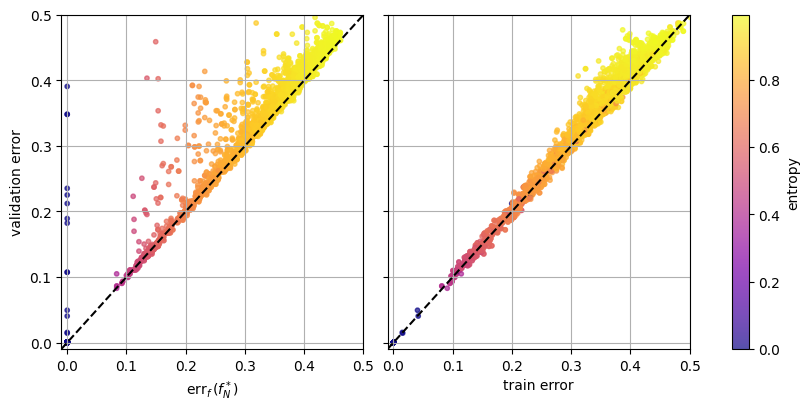

In [96]:
# "we are fitting the data well"
fig, axes = plt.subplots(1, 2,figsize=(8, 4), constrained_layout=True, sharey=True)

# Compute 2D histogram
scatters = []
for i, xvals in enumerate([df['err_g'], 1 - df['train_acc']]):
    ax = axes[i]
    scatter = ax.scatter( xvals, 1 - df['val_acc'], c=df["entropy"], cmap='plasma', alpha=0.7, s=10)
    scatters.append(scatter)
# Add a colorbar for the first scatter plot
fig.colorbar(scatters[0], ax=axes, label='entropy')


axes[0].set_ylabel('validation error')
axes[0].set_xlabel(r'err$_f\,(f_N^*)$')

axes[1].set_xlabel('train error')

for ax in axes:
    ax.set_xlim([-0.01, 0.5])
    ax.set_ylim([-0.01, 0.5])
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    low = max(xmin, ymin)
    high = min(xmax, ymax)
    ax.grid(True)
    ax.plot([low, high], [low, high], ls='--', c='k')

# h = ax0.hist2d(1 - df['val_acc'], df['err_g'], bins=25, cmap='viridis')
# fig.colorbar(h[3], ax=ax0, label='Count')
# ax0.set_xlabel('Validation error')
# ax0.set_ylabel(r'err$_f\,(f_N^*)$')
# # ax.set_title('2D Histogram: Val Accuracy vs. 1 - err_g (lr != 0.008, 0.01)')



plt.savefig("figures/app_fig2_overfit.pdf", bbox_inches='tight')

In [90]:

scatter = ax1.scatter(1 - df['val_acc'], df['err_g'], c=df["entropy"], cmap='plasma', alpha=0.7, s=10)
cbar = fig.colorbar(scatter)
cbar.set_label("entropy")
ax1.set_xlabel('Validation error')
ax1.set_ylabel(r'err$_f\,(f_N^*)$')
ax1.grid(True)


for ax in axes:
    ax.set_xlim([-0.01, 0.5])
    ax.set_ylim([-0.01, 0.5])
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    low = max(xmin, ymin)
    high = min(xmax, ymax)
    ax.grid(True)
    ax.plot([low, high], [low, high], ls='--', c='k')

plt.savefig("figures/app_fig2_overfit.pdf", bbox_inches='tight')

<Figure size 640x480 with 0 Axes>